In [210]:
import numpy as np
import matplotlib.pyplot as plt
from pycbc import fft
from pycbc.filter import match, overlap_cplx, sigma, sigmasq, make_frequency_series, get_cutoff_indices
from pycbc.psd import aLIGOZeroDetHighPower
from pycbc.types import timeseries, frequencyseries, zeros, complex_same_precision_as
from calcwf import gen_wf, chirp2total, get_h

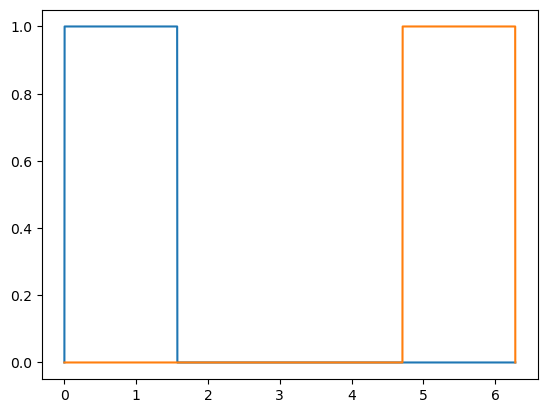

In [25]:
# Create two time series objects
a = np.zeros(4096)
a[1:1025] = 1
b = np.zeros(4096)
b[3071:4095] = 1
a_ts = timeseries.TimeSeries(a, 2*np.pi/4096)
b_ts = timeseries.TimeSeries(b, 2*np.pi/4096)
plt.plot(a_ts.sample_times, a_ts, label='a')
plt.plot(b_ts.sample_times, b_ts, label='b')
plt.show()

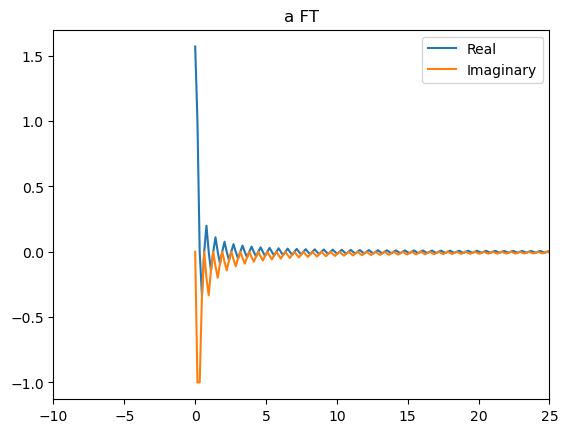

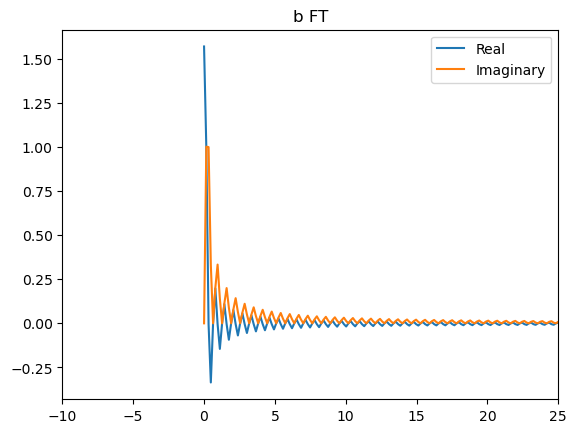

In [46]:
# Fourier transform to frequency series objects and plot
a_fs = a_ts.to_frequencyseries()
b_fs = b_ts.to_frequencyseries()

# a FT
plt.plot(a_fs.sample_frequencies, a_fs.real(), label='Real')
plt.plot(a_fs.sample_frequencies, a_fs.imag(), label='Imaginary')
plt.legend()
plt.title('a FT')
plt.xlim(-10,25)
plt.show()

# b FT
plt.plot(b_fs.sample_frequencies, b_fs.real(), label='Real')
plt.plot(b_fs.sample_frequencies, b_fs.imag(), label='Imaginary')
plt.legend()
plt.title('b FT')
plt.xlim(-10,25)
plt.show()

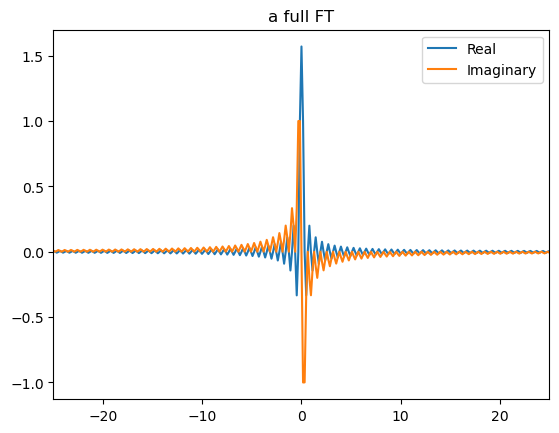

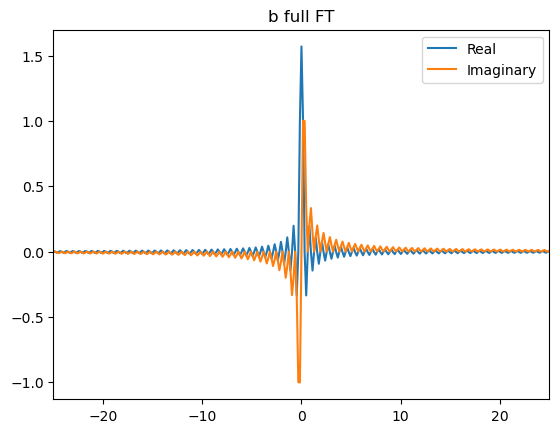

In [67]:
# Construct full FT for both
max_f = max(a_fs.sample_frequencies)
delta_f = np.mean(np.diff(a_fs.sample_frequencies))
full_fs = np.linspace(-max_f, max_f, 2*int(max_f/delta_f)+1)

# a full FT
full_a_fs = np.zeros(len(full_fs),dtype='complex128')
full_a_fs[int(max_f/delta_f):] = np.array(a_fs)
full_a_fs[:int(max_f/delta_f)] = np.flip(np.conj(np.array(a_fs)[1:]))
plt.plot(full_fs, np.real(full_a_fs), label='Real')
plt.plot(full_fs, np.imag(full_a_fs), label='Imaginary')
plt.legend()
plt.title('a full FT')
plt.xlim(-25,25)
plt.show()

# b full FT
full_b_fs = np.zeros(len(full_fs),dtype='complex128')
full_b_fs[int(max_f/delta_f):] = np.array(b_fs)
full_b_fs[:int(max_f/delta_f)] = np.flip(np.conj(np.array(b_fs)[1:]))
plt.plot(full_fs, np.real(full_b_fs), label='Real')
plt.plot(full_fs, np.imag(full_b_fs), label='Imaginary')
plt.legend()
plt.title('b full FT')
plt.xlim(-25,25)
plt.show()

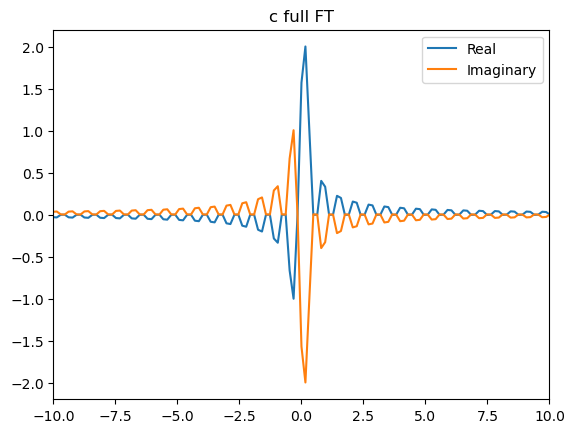

In [75]:
# Add both as c = a-ib to make complex combination
full_c_fs = full_a_fs - 1j*full_b_fs
plt.plot(full_fs, np.real(full_c_fs), label='Real')
plt.plot(full_fs, np.imag(full_c_fs), label='Imaginary')
plt.legend()
plt.title('c full FT')
plt.xlim(-10,10)
plt.show()

Now try achieving the same with pycbc's C2C fft function

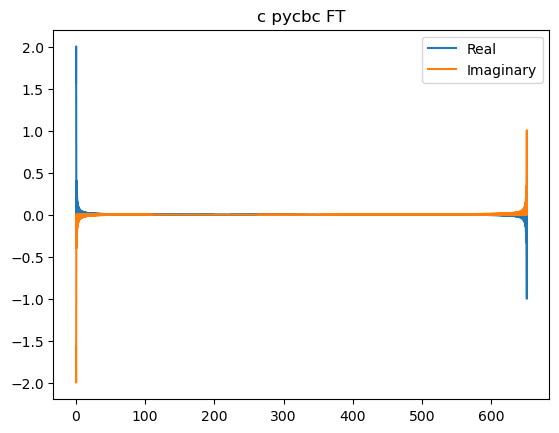

In [226]:
# Create c as complex timeseries, and corresponding out-vector
c_ts = a_ts - 1j*b_ts
c_fs = frequencyseries.FrequencySeries(np.zeros(len(c_ts), dtype='complex128'), delta_f=1/c_ts.duration)

# Perform C2C fft
fft.fft(c_ts, c_fs)

# Plot c_fs
plt.plot(c_fs.sample_frequencies, c_fs.real(), label='Real')
plt.plot(c_fs.sample_frequencies, c_fs.imag(), label='Imaginary')
plt.legend()
plt.title('c pycbc FT')
#plt.xlim(641,661)
plt.show()

This is clearly not quite what we want. Appears that taking second half of frequencies above and appending to start as negative frequencies would however achieve the correct result. Main problem is that the pycbc FrequencySeries object has no way of defining negative frequencies.

In order to solve this, we could input a psd which is mirrorred across the middle frequency above, and set the high frequency limit to also mirror the low frequency limit. This should then work to get the desired result from the integral (and hopefully not cause any issues with time/phase maximisation).

We want to convert the psd to this mirrorred psd in exactly the same way that we would convert from a psd describing full_c_fs above to c_fs. We therefore want to understand exactly (down to the index) how to transform full_c_fs to create c_fs (paying particular attention to ensuring this works for odd and even lengths).

In [227]:
# Manual fft
print(full_c_fs[2043:2054])

# pycbc C2C fft
print(c_fs[-5:], c_fs[:6])

[-0.00305615+0.00307968j  0.        -0.j         -0.66512447+0.6681924j
 -1.00152378+1.00460114j -0.00306561+0.00307031j  1.57079633-1.57079633j
  2.00153123-1.99846328j  0.99845582-0.99539729j -0.003075  +0.00306089j
  0.        +0.j          0.40152021-0.39845234j]
[-0.00305615+0.00307968j  0.        +0.j         -0.66512447+0.6681924j
 -1.00152378+1.00460114j -0.00306561+0.00307031j] [ 1.57079633-1.57079633j  2.00153123-1.99846328j  0.99845582-0.99539729j
 -0.003075  +0.00306089j  0.        +0.j          0.40152021-0.39845234j]


c_ts here has an even length, and there is an f=0 point on the left but not the right.

In [231]:
# Create odd a and b timeseries, and convert to full frequency series
a_ts_odd = a_ts[:-1]
b_ts_odd = b_ts[:-1]
a_fs_odd = a_ts_odd.to_frequencyseries()
b_fs_odd = b_ts_odd.to_frequencyseries()
max_f_odd = max(a_fs_odd.sample_frequencies)
delta_f_odd = np.mean(np.diff(a_fs_odd.sample_frequencies))
full_fs_odd = np.linspace(-max_f_odd, max_f_odd, 2*int(max_f_odd/delta_f_odd)+1)
full_a_fs_odd = np.zeros(len(full_fs_odd),dtype='complex128')
full_a_fs_odd[int(max_f_odd/delta_f_odd):] = np.array(a_fs_odd)
full_a_fs_odd[:int(max_f_odd/delta_f_odd)] = np.flip(np.conj(np.array(a_fs_odd)[1:]))
full_b_fs_odd = np.zeros(len(full_fs_odd),dtype='complex128')
full_b_fs_odd[int(max_f_odd/delta_f_odd):] = np.array(b_fs_odd)
full_b_fs_odd[:int(max_f_odd/delta_f_odd)] = np.flip(np.conj(np.array(b_fs_odd)[1:]))

# Create manual fft of c
full_c_fs_odd = full_a_fs_odd - 1j*full_b_fs_odd

# Create c as complex timeseries, and corresponding out-vector
c_ts_odd = a_ts_odd - 1j*b_ts_odd
c_fs_odd = frequencyseries.FrequencySeries(np.zeros(len(c_ts_odd), dtype='complex128'), delta_f=1/c_ts_odd.duration)

# Perform C2C fft
fft.fft(c_ts_odd, c_fs_odd)

# Manual fft
print(full_c_fs_odd[2042:2053])

# pycbc C2C fft
print(c_fs_odd[-5:], c_fs_odd[:6])

[-1.91931126e-03+1.91931126e-03j  3.82021897e-04-3.82021897e-04j
 -6.66118132e-01+6.66118132e-01j -1.00167181e+00+1.00167181e+00j
 -1.91784360e-03+1.91784360e-03j  1.57079633e+00-1.57079633e+00j
  1.99989445e+00-1.99989445e+00j  9.97836864e-01-9.97836864e-01j
 -1.91637143e-03+1.91637143e-03j  3.84963983e-04-3.84963983e-04j
  4.00282035e-01-4.00282035e-01j]
[-1.91931126e-03+1.91931126e-03j  3.82021897e-04-3.82021897e-04j
 -6.66118132e-01+6.66118132e-01j -1.00167181e+00+1.00167181e+00j
 -1.91784360e-03+1.91784360e-03j] [ 1.57079633e+00-1.57079633e+00j  1.99989445e+00-1.99989445e+00j
  9.97836864e-01-9.97836864e-01j -1.91637143e-03+1.91637143e-03j
  3.84963983e-04-3.84963983e-04j  4.00282035e-01-4.00282035e-01j]


The same is true here - c_fs from pycbc C2C fft always has the f=0 point on the left, never on the right, no matter whether c_ts has odd or even length.

We therefore only want the f=0 part of the psd on the left, not on the right. If the length is then even, this means we want the 'middle' point of the complex psd (or last point of regular psd) to be repeated only once instead of twice in order to make sure the psd and signals have the same lengths.

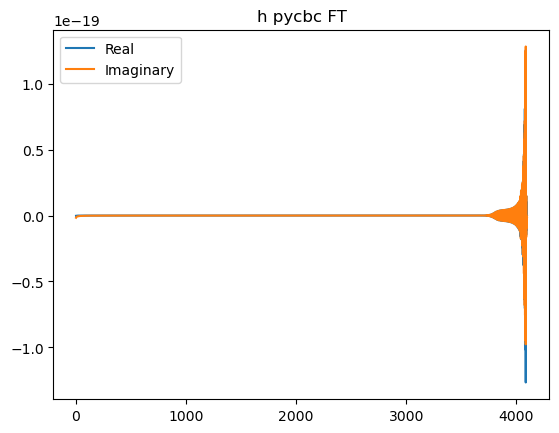

In [261]:
# Now get complex TEOB waveform to test with
h = gen_wf(10, 0.1, chirp2total(24,2), 2, 4096, 'TEOBResumS')
h_fs = frequencyseries.FrequencySeries(np.zeros(len(h), dtype='complex128'), delta_f=1/h.duration)

# Perform C2C fft
fft.fft(h, h_fs)

# Plot c_fs
plt.plot(h_fs.sample_frequencies, h_fs.real(), label='Real')
plt.plot(h_fs.sample_frequencies, h_fs.imag(), label='Imaginary')
plt.legend()
plt.title('h pycbc FT')
plt.show()

All the power here is in the 'negative' frequencies, which is slightly odd, but likely just due to positive frequencies cancelling out.

(2045.0, 2051.0)

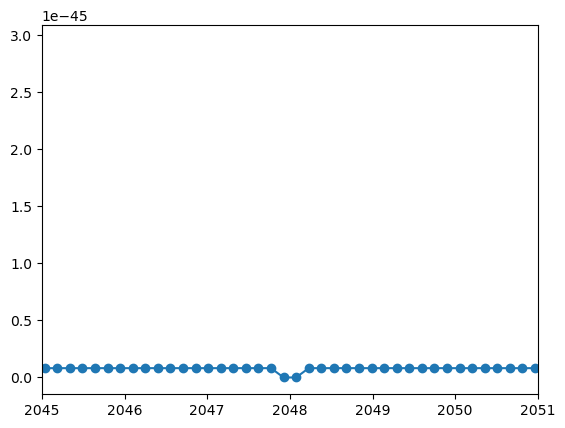

In [251]:
# Default PSD
delta_f = 1.0 / h.duration
flen = len(h)//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, 13)

# Complex PSD
cplx_psd = np.zeros(len(h))
cplx_psd[:flen] = psd
if len(h)%2 == 0:
    cplx_psd[flen:] = np.flip(psd[1:-1])
else:
    cplx_psd[flen:] = np.flip(psd[1:])
plt.plot(np.arange(len(cplx_psd))*delta_f, cplx_psd)
plt.scatter(np.arange(len(cplx_psd))*delta_f, cplx_psd)
plt.xlim(2045,2051)

There are two values in the middle which are zero, which would cause issues if included. Usually the last index of the psd is excluded by default so this is not an issue. Here we can simply set their value to the adjacent one as the power in the waveforms should be negligible here anyway. Note that if the length of h had been even, there would only be one point here.

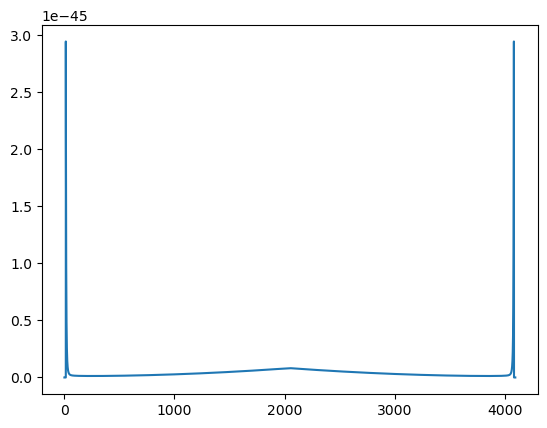

In [252]:
# Default PSD
delta_f = 1.0 / h.duration
flen = len(h)//2 + 1
psd = aLIGOZeroDetHighPower(flen, delta_f, 13)

# Complex PSD
cplx_psd = np.zeros(len(h))
cplx_psd[:flen] = psd
if len(h)%2 == 0:
    cplx_psd[flen:] = np.flip(psd[1:-1])
else:
    cplx_psd[flen:] = np.flip(psd[1:])
cplx_psd[int(len(cplx_psd)/2):int(len(cplx_psd)/2)+1+(len(h)%2)] = cplx_psd[int(len(cplx_psd)/2)-1]
cplx_psd = frequencyseries.FrequencySeries(cplx_psd, delta_f=delta_f)
plt.plot(cplx_psd.sample_frequencies, cplx_psd)

Now figure out the high frequency cutoff required. As the f=0 point is on the left side only, the low/high freq limits should be that one more data point is cut from the left than the right.

In [253]:
get_cutoff_indices(13, None, h_fs.delta_f, (len(h_fs)-1) * 2)

(85, 26934)

85 points are cutoff from the left, so we wish to cut off 84 from the left. We therefore want the second cutoff index to be 26851.

In [254]:
low_cutoff_ind = int(13/h_fs.delta_f)
high_cutoff_ind = len(h_fs) - (low_cutoff_ind - 1)
high_cutoff_freq = high_cutoff_ind*h_fs.delta_f
get_cutoff_indices(13, high_cutoff_freq, h_fs.delta_f, (len(h_fs)-1) * 2)

(85, 26851)

This is achieved as so.

I will now write a function in calcwf.py to generate a complex psd, along with the high frequency cutoff.